# Desafió AInwater

Objetivos: caracterizar el funcionamiento de la planta durante esta semana.
* hz totales por ciclo
* crear un label que identifique cual es en que posición del día se encuentra cada ciclo
* comparar el gasto energético entre los diferentes ciclos de cada día
* nivel medio de oxígeno por ciclo (y su distribución)
* nivel medio de oxígeno por ciclo para blower_hz > 0 (y su distribución)

bonus:
* caracterizar el nivel de agua por ciclo
* desarrollar un modelo de clusterización de los ciclos de esta semana

Variables:
* date = fecha de la lectura
* time = hora de la lectura
* do_level = nivel de oxígeno
* h2o_level = nivel de agua
* blower_hz = hz de giro del motor
* cycle_id = label para identificar los ciclos de funcionamiento

Este documento se encuentra divido en 5 partes:

1. [Exploración de datos](#S1)
1. [Análisis Soplador](#S2)
1. [Análisis del Nivel de O<sub>2</sub>](#S3)
1. [Análisis del Nivel de H<sub>2</sub>O](#S4)
1. [Modelo de clusterización de los ciclos de esta semana](#S5)

## 1. Exploración de datos <a id="S1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, 'Script')

In [2]:
path_src = "Data/base_test_planta_tupiniquim.csv"
df = pd.read_csv(path_src)
df.head()

Unnamed: 0        date      time  do_level  h2o_level  blower_hz  cycle_id
0        6285  2021-04-14  00:00:28  1.693960   4.931112        0.0         0
1        6287  2021-04-14  00:02:35  1.401860   4.930655        0.0         0
2        6288  2021-04-14  00:05:35  1.134430   4.929771        0.0         0
3        6289  2021-04-14  00:08:35  0.929321   4.930228        0.0         0
4        6290  2021-04-14  00:11:35  0.882311   4.928187        0.0         0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3366 non-null   int64  
 1   date        3366 non-null   object 
 2   time        3366 non-null   object 
 3   do_level    3366 non-null   float64
 4   h2o_level   3366 non-null   float64
 5   blower_hz   3366 non-null   float64
 6   cycle_id    3366 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 184.2+ KB


In [4]:
df.set_index(["date","time"]).duplicated().unique()

array([False])

**Comentarios:**
* De acuerdo a las funciones antoriores, se  observa un nombre de una columna faltante, correspondiente al id del registro. Además, se observa que las columnas "date" y "time" contienen variables del tipo objecto, mientrass que el resto presenta variables enteras (int) o flotantes (float).
* Además, se presentan un total de 3366 entradas, sin presentar datos faltantes, sin presentar registros duplicados.
* Por lo tanto, a traves de la función "read_csvdata" se lee el dataframe especificando el tipo variable al que corresponde cada columna, se crea un label que identifica cual es la posición del día se encuentra cada ciclo con el nombre "datetime", se añaden las columnas año ("year"), mes ("month") y día ("día"), y se renombra la variable "Unnamed: 0" por "registro_id", variable que se define como índice.

In [5]:
from read_data import read_csvdata
type_columns = {
    "date"      : str,
    "time"      : str,
    "do_level"  : float,
    "h2o_level" : float,
    "blower_hz" : float,
    "cycle_id"  : int
}

df = read_csvdata(path_src, type_columns)
df.head()

date      time  do_level  h2o_level  blower_hz  cycle_id  \
registro_id                                                                   
6285         2021-04-14  00:00:28  1.693960   4.931112        0.0         0   
6287         2021-04-14  00:02:35  1.401860   4.930655        0.0         0   
6288         2021-04-14  00:05:35  1.134430   4.929771        0.0         0   
6289         2021-04-14  00:08:35  0.929321   4.930228        0.0         0   
6290         2021-04-14  00:11:35  0.882311   4.928187        0.0         0   

                       datetime  year  month  day  
registro_id                                        
6285        2021-04-14 00:00:28  2021      4   14  
6287        2021-04-14 00:02:35  2021      4   14  
6288        2021-04-14 00:05:35  2021      4   14  
6289        2021-04-14 00:08:35  2021      4   14  
6290        2021-04-14 00:11:35  2021      4   14

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 6285 to 9657
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3366 non-null   object        
 1   time       3366 non-null   object        
 2   do_level   3366 non-null   float64       
 3   h2o_level  3366 non-null   float64       
 4   blower_hz  3366 non-null   float64       
 5   cycle_id   3366 non-null   int32         
 6   datetime   3366 non-null   datetime64[ns]
 7   year       3366 non-null   int64         
 8   month      3366 non-null   int64         
 9   day        3366 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(3), object(2)
memory usage: 276.1+ KB


In [7]:
# Resumen estadistico
def cv_estimator(x):
    return x.std()/x.mean()

print("Coeficiente de variación:")
display(df[["do_level", "h2o_level", "blower_hz", "cycle_id"]].agg(cv_estimator, axis=0))
print("\nResumen Estadístico:")
display(df.loc[:, ~df.columns.isin(["year", "month", "day"])].describe().T)
print("\nCorrelación entre variables")
display(df.loc[:, ~df.columns.isin(["year", "month", "day"])].corr())

Coeficiente de variación:


do_level     1.162882
h2o_level    0.096702
blower_hz    1.630809
cycle_id     0.573379
dtype: float64


Resumen Estadístico:


count       mean        std       min       25%        50%  \
do_level   3366.0   1.360852   1.582510  0.004908  0.057467   0.603368   
h2o_level  3366.0   4.586752   0.443547  3.910520  4.253216   4.397857   
blower_hz  3366.0  12.140579  19.798966  0.000000  0.000000   0.000000   
cycle_id   3366.0  17.574569  10.076893  0.000000  9.000000  18.000000   

                 75%        max  
do_level    2.339908   5.716060  
h2o_level   5.018035   5.412021  
blower_hz  26.440001  50.240002  
cycle_id   26.000000  35.000000


Correlación entre variables


do_level  h2o_level  blower_hz  cycle_id
do_level   1.000000  -0.065409   0.023279  0.022395
h2o_level -0.065409   1.000000  -0.081768  0.063728
blower_hz  0.023279  -0.081768   1.000000  0.030905
cycle_id   0.022395   0.063728   0.030905  1.000000

**Comentarios:**
* En nivel de oxígeno (do_level) presenta mayor variación en relación a su media, con valores registrados que fluctuan desde 0.005 a 5.716 aproximadamente.
* En nivel de agua (h2o_level) presenta menor variación en relación a su media, con valores registrados que fluctuan desde 0.5 a 5.5 aproximadamente.
* Los Hz usados por el soplador (blower_hz) presenta mayor variación en relación a su media, con valores registrados que fluctuan desde 0 a 50.240 aproximadamente. Además, se observa una mediana entorno a 0, debido a que el uso del soplador no es continuo, como se observa en la siguiente figura que representa la serie de tiempo para los Hz del soplador en cada ciclo.
* Finalmente, entre cada una de las variables no existe una linealidad debido a que los valores para el coeficiente de correlación lineal están cerca de 0.

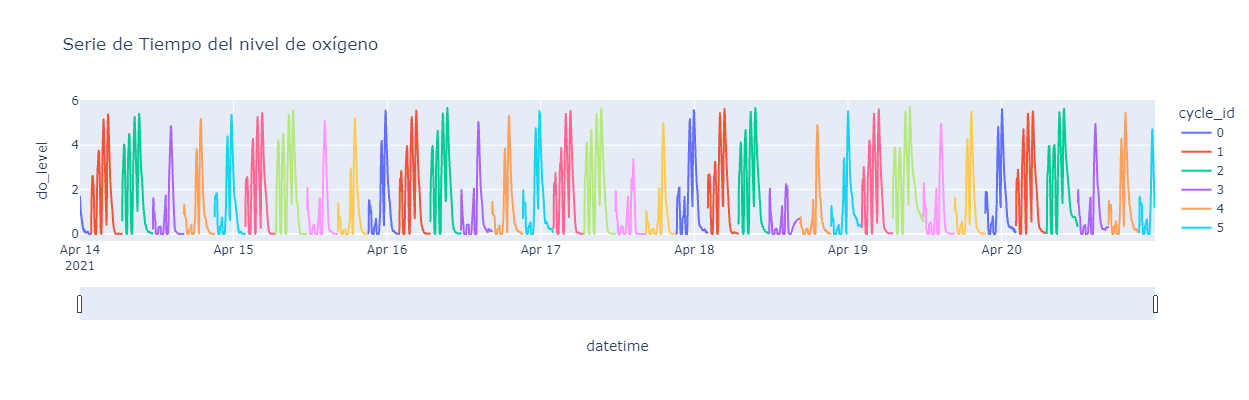

In [8]:
# nivel de oxígeno
import plotly.express as px
fig = px.line(df, x="datetime", y='do_level', color="cycle_id", title='Serie de Tiempo del nivel de oxígeno')

fig.update_layout(height=400)
fig.write_image("Output/images/ST-do_level.png")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

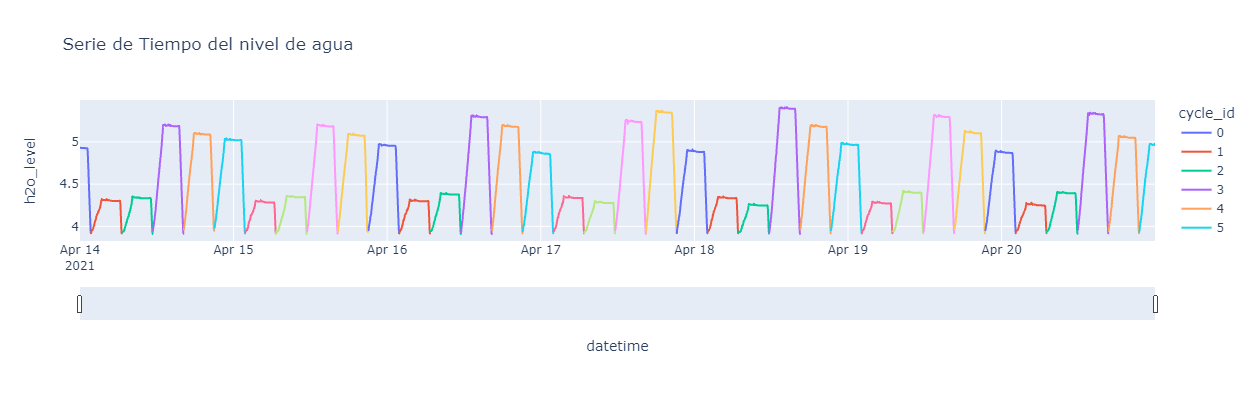

In [9]:
# nivel de agua
fig = px.line(df, x="datetime", y='h2o_level', color="cycle_id", title='Serie de Tiempo del nivel de agua')

fig.update_layout(height=400)
fig.write_image("Output/images/ST-h2o_level.png")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

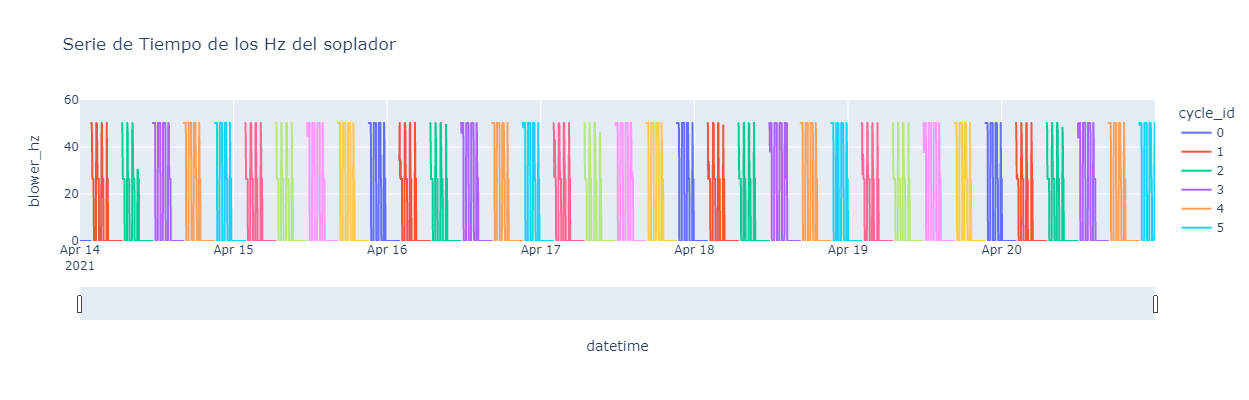

In [10]:
# Hz correspondientes al motor del soplador
fig = px.line(df, x="datetime", y='blower_hz', color="cycle_id", title='Serie de Tiempo de los Hz del soplador')

fig.update_yaxes(range = [0, 60])
fig.update_layout(height=400)
fig.write_image("Output/images/ST-blower_hz.png")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## 2. Análisis Soplador <a id="S2"></a>

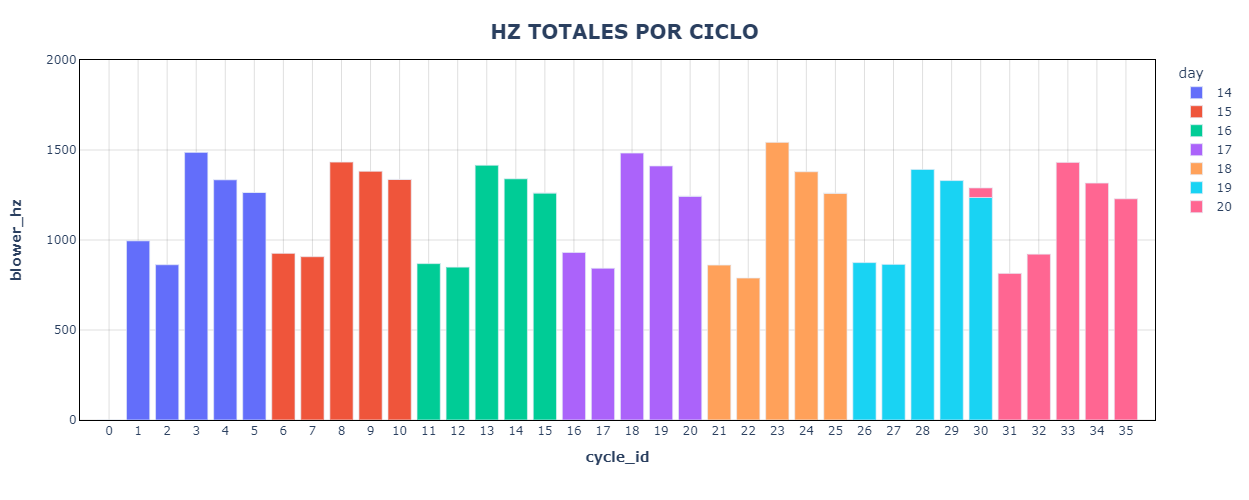

In [11]:
# Hz totales por ciclo
from plot import bar_by_cycle_sum
title = {
    "blower_hz"  : "<b>Hz totales por ciclo</b>",
    "do_level"   : "<b>O<sub>2</sub> total por ciclo</b>",
    "h2o_level"  : "<b>H<sub>2</sub>O total por ciclo</b>"
}
fig = bar_by_cycle_sum(
    df, "blower_hz", title = title, col_color = "day", 
    col_hover_data = ["do_level", "h2o_level", "month", "year"], height = 500, width=1100
)
fig.write_image("Output/images/bar_by_cycle_sum-blower_hz.png")
fig.show()

**Comentarios**
* Complementando a las series de tiempo en la sección de [Exploración de datos](#S1), se observa en la planta de tratamiento un mayor flujo procesado en los ciclos del motor correspondientes a las tardes-noches.
* Lo anterior lleva a un mayor gasto energético por parte del soplador, debido principalmente al nivel de oxígeno necesario para el correcto funciomamiento de la etapa aerobia del proceso productivo.
* Además, en este gráfico se añaden el nivel de oxígeno medio, nivel de agua medio, mes y año.

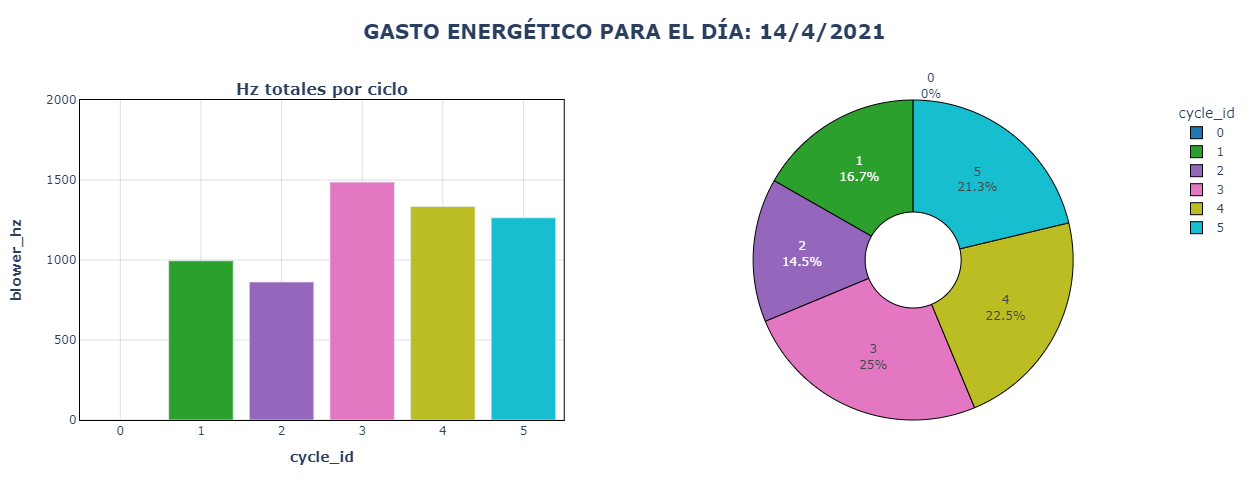

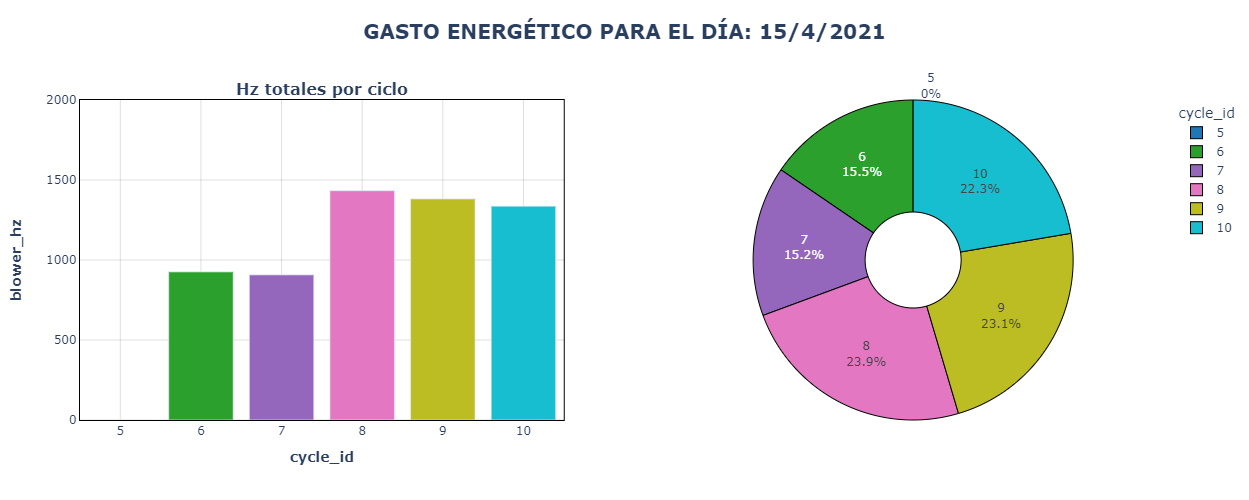

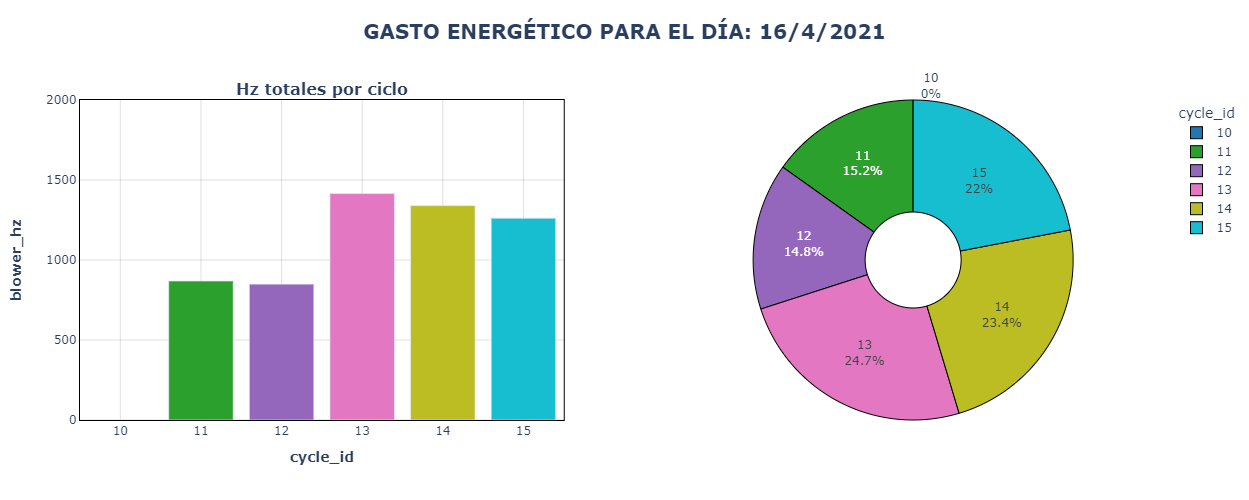

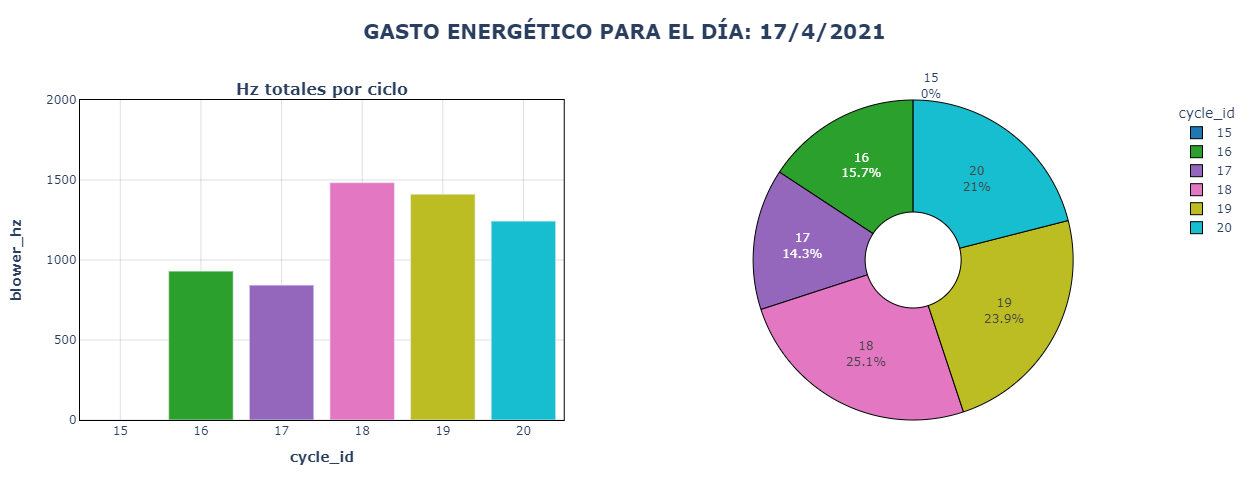

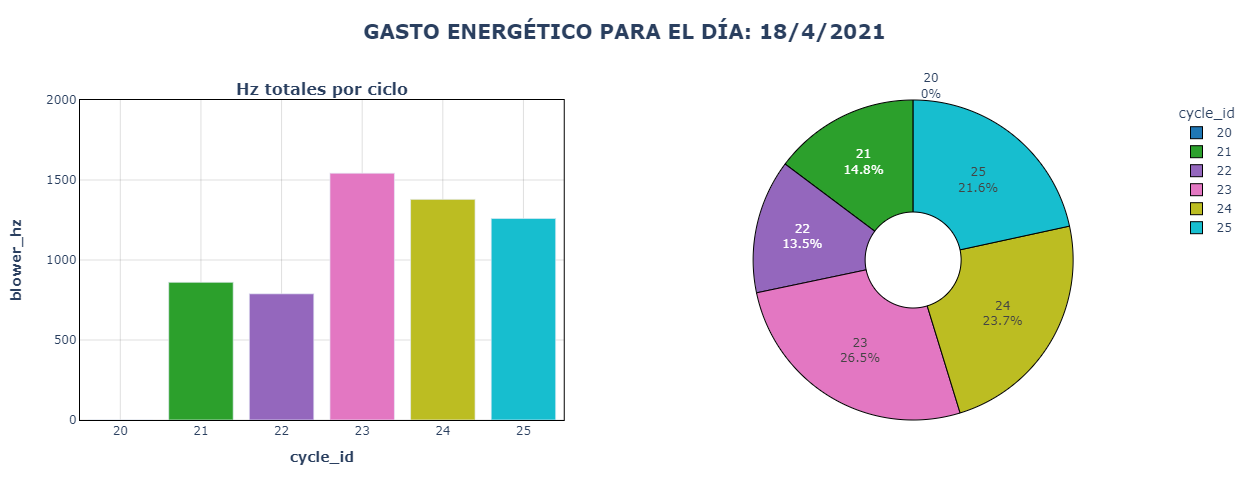

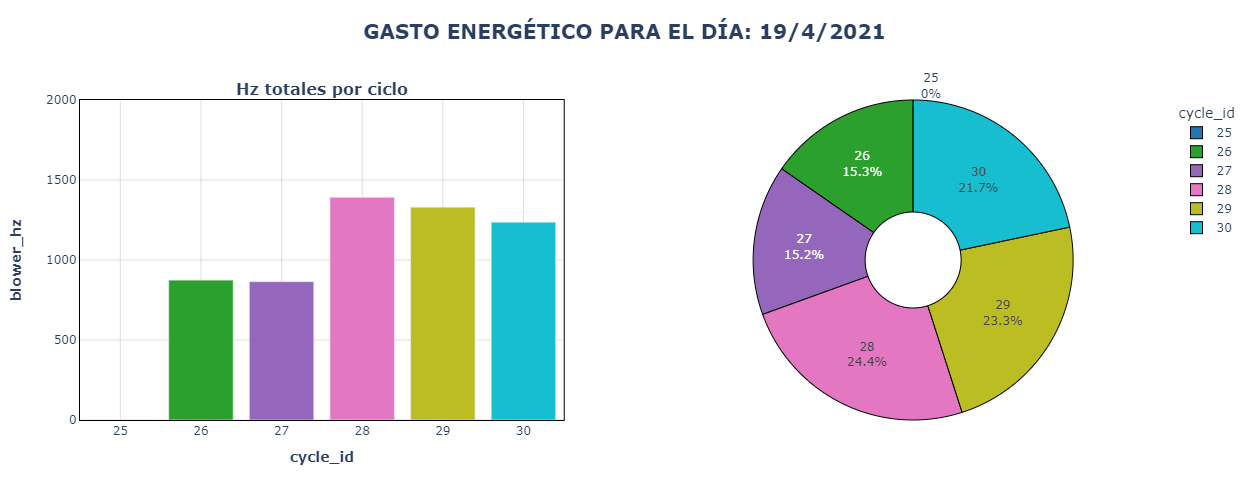

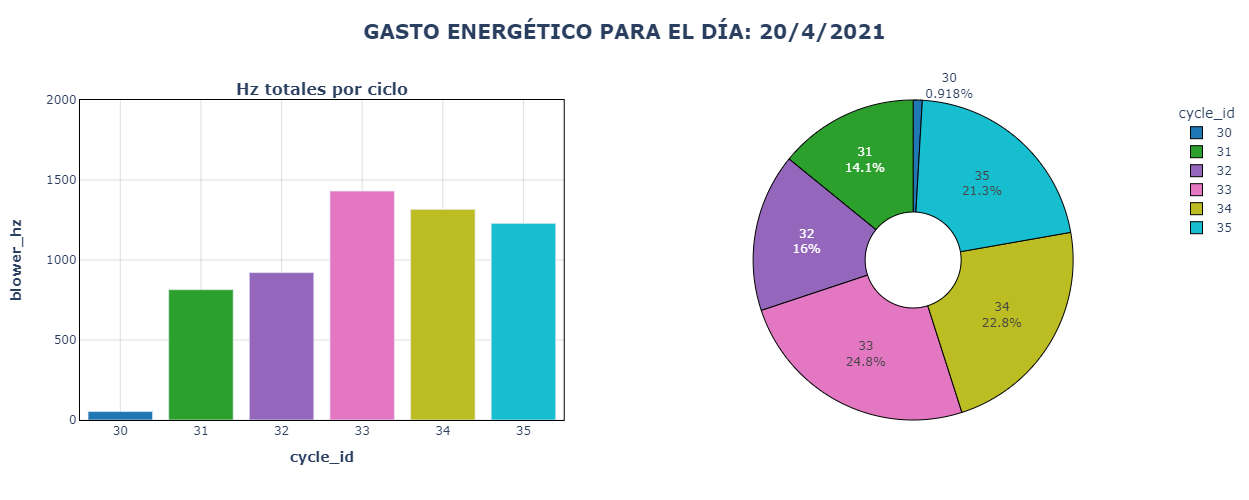

In [12]:
from plot import gastoenergetico_por_dia

for day in df.day.unique():
    fig = gastoenergetico_por_dia(df = df, query="day == "+str(day), col_labels="cycle_id", col_values="blower_hz",
                                  subtitle = "Hz totales por ciclo", col_hover_data = ["do_level", "h2o_level", "month", "year"],
                                  height = 500, width=1000)
    fig.write_image("Output/images/gastoenergetico_por_dia-"+str(day)+"-04-2021.png")
    fig.show()

**Comentarios**
* De acuerdo a cada uno de los gráficos para cada día, los tres últimos ciclos de funcionamiento del motor presentan un consume que varia entre 20% a 25%. Adicionalmente, los ciclos 3, 8, 13, 18, 23, 28 y 33 ubicados en la 4ta posición de izquierda a derecha, presentan el consumo energético máximo.
* El primer ciclo de funcionamiento de cada día presenta un total de 0 Hz a excepción del día 20/04/2021, esto debido a que en ese día el motor del soplador presento su último accionamiento pasada las 24:00 hrs.

## 3. Análisis del Nivel de O<sub>2</sub>. <a id="S3"></a>

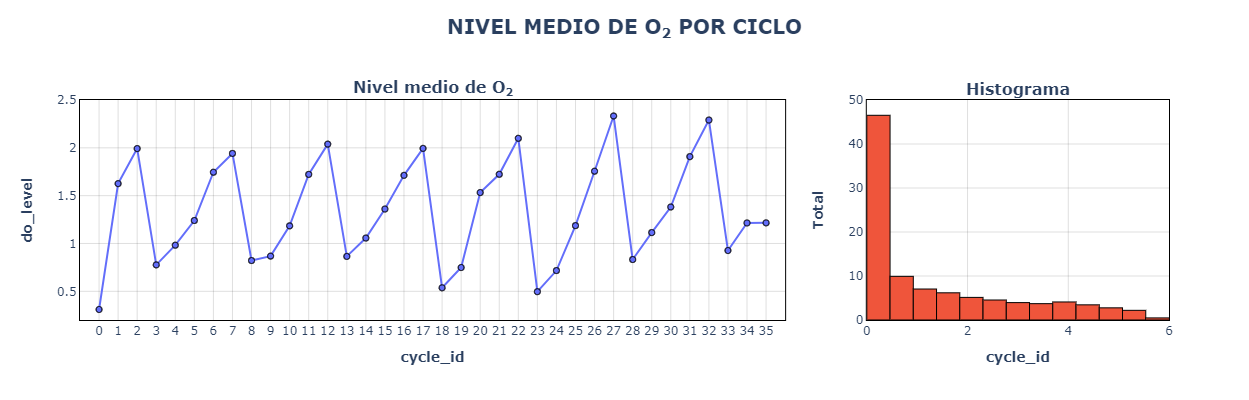

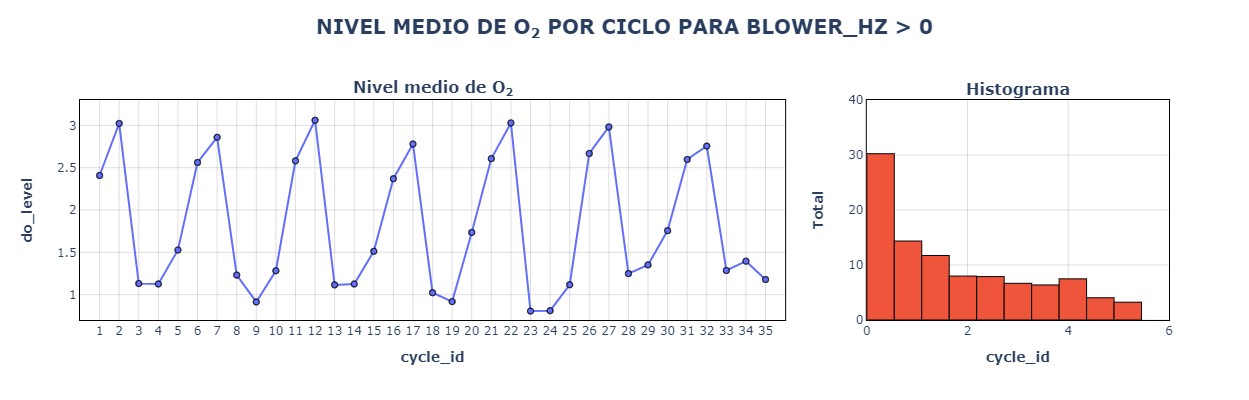

In [13]:
from plot import bar_by_cycle_mean

title = {
    "blower_hz"  : "<b>Nivel medio de Hz</b>",
    "do_level"   : "<b>Nivel medio de O<sub>2</sub></b>",
    "h2o_level"  : "<b>Nivel medio de H<sub>2</sub>O</b>"
}

# Para todo los datos 
fig = bar_by_cycle_mean(df, "do_level", title = title, height = 400, width=1200)
fig.show()
fig.write_image("Output/images/bar_by_cycle_mean-do_level.png")

# Para blower_hz > 0
fig2 = bar_by_cycle_mean(df, "do_level", title = title, query_text = "blower_hz > 0", height = 400, width=1200)
fig2.show()
fig.write_image("Output/images/bar_by_cycle_mean-do_level-with-query.png")

**Comentarios**
* Recordando de [Exploración de datos](#S1), el nivel de oxígeno (do_level) presenta mayor variación en relación a su media, con valores registrados que fluctuan desde 0.005 a 5.716 aproximadamente, con una media entorno a un valor de 1.36, una desviación estandar de 1,58 y una mediana de 0.6.
* De acuerdo a ambas gráficas, considerando todos los valores de la variable "blower_hz" se observan oscilaciones entre 0.5 a 2.5 respecto el nivel de oxígeno necesario. No obstante, cuando se filtran los resultados cuando el motor del soplador no está funcionando, es decir, no considerar los valores de "blower_hz = 0", el nivel medio de O<sub>2</sub> puede alcanzar valores de 3.
* Referente a los histogramas, ambos presentan una distribución exponencial. En el primer histograma (el que considera todos los valores de la variable "blower_hz") la clase "0 - 0.462" es presenta por sobre 40% de los datos. Por otro lado, cuando se filtran los resultados de la variable "blower_hz", la clase "0 - 0.544" presenta cerca de un 30% de los datos.
* De acuerdo a ambas gráficas, antes de que se produzca un mayor consumo energético en cada uno de los ciclos, es decir, los ciclos 3, 8, 13, 18, 23, 28 y 33, los niveles medios de oxígeno se encuentran por sobre los otros ciclos de funcionamiento de cada día. Este efecto ocurre debido al aumento en el flujo a tratar, y por ende, los niveles de oxígeno en el proceso aerobio disminuyen por una crecida en el volumen a tratar.

## 4. Análisis del Nivel de H<sub>2</sub>O. <a id="S4"></a>

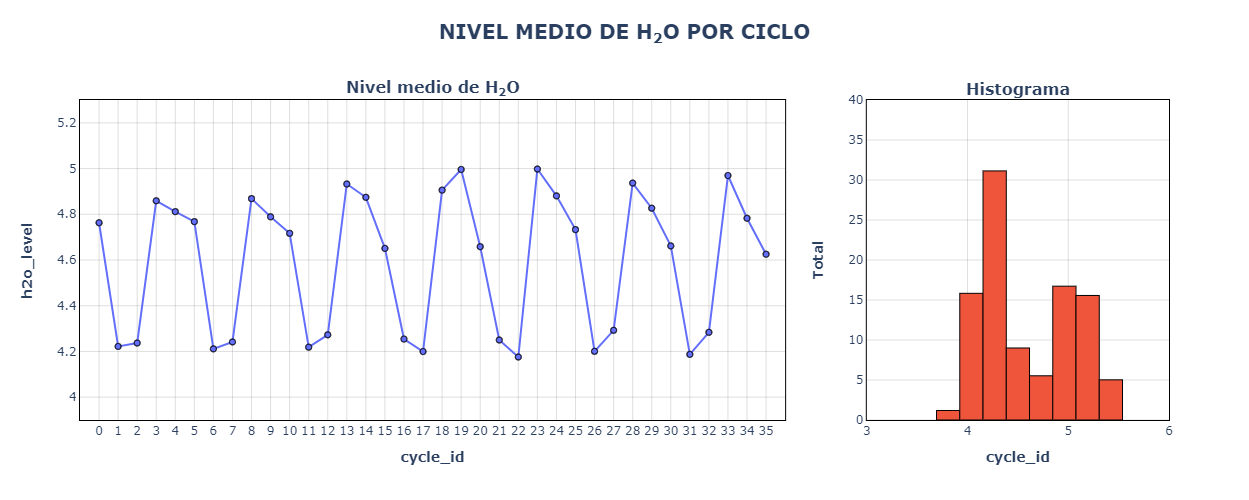

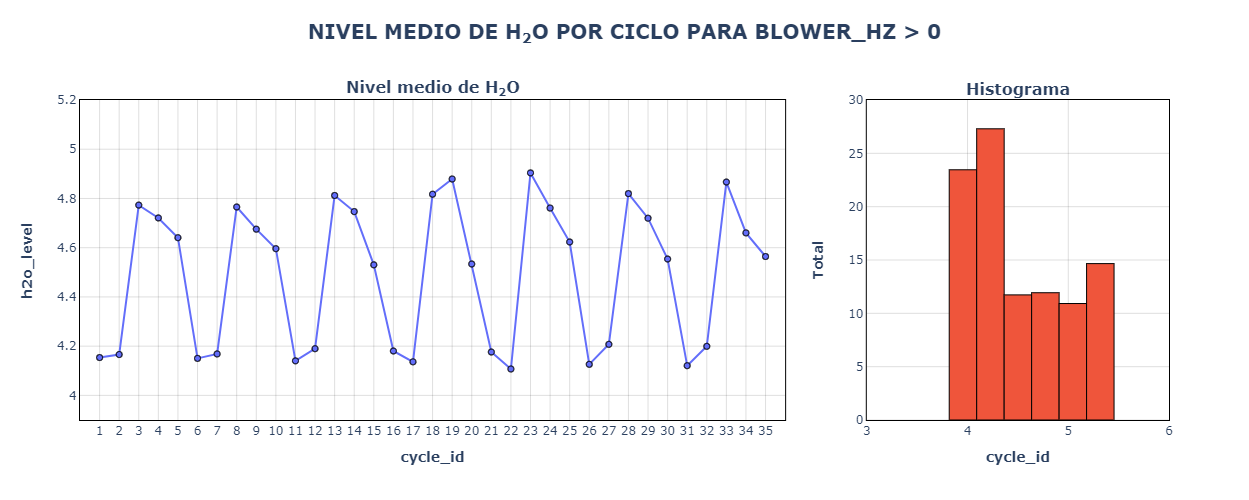

In [14]:
# Para todo los datos 
fig = bar_by_cycle_mean(df, "h2o_level", title = title, height = 500, width=1200)
fig.show()
fig.write_image("Output/images/bar_by_cycle_mean-h2o_level.png")

# Para blower_hz > 0
fig2 = bar_by_cycle_mean(df, "h2o_level", title = title, query_text = "blower_hz > 0", height = 500, width=1200)
fig2.show()
fig.write_image("Output/images/bar_by_cycle_mean-h2o_level-with-query.png")

**Comentarios**
* Recordando de [Exploración de datos](#S1), el nivel de agua (h2o_level) presenta menor variación en relación a su media, con valores registrados que fluctuan desde 0.5 a 5.5 aproximadamente, con una media entorno a un valor de 4.59, una desviación estandar de 0.44 y una mediana de 4.40.
* De acuerdo a ambas gráficas, presentan un nivel de agua entre 4 a 5. No obstante, cuando se filtran los resultados, es decir, "blower_hz > 0", el nivel medio de H<sub>2</sub>O sube levemente.
* Respecto a los histogramas, considerando todos los valores de la variable "blower_hz" se presenta una distribución bimodal. No obstante, cuando se filtran los valores de la variable "blower_hz" esta distribución pasa a ser una distribución normal con un sesgo hacia la derecha.
* De acuerdo a ambas gráficas, cuando se produce un mayor consumo energético en cada uno de los ciclos, es decir, los ciclos 3, 8, 13, 18, 23, 28 y 33, los niveles medios de agua se encuentran por sobre los otros ciclos de funcionamiento de ese día.

## 5. Modelo de clusterización de los ciclos de esta semana. <a id="S5"></a>

In [15]:
# Resumen estadistico
def cv_estimator(x):
    return x.std()/x.mean()

print("Coeficiente de variación:")
display(df[["do_level", "h2o_level", "blower_hz", "cycle_id"]].agg(cv_estimator, axis=0))
print("\nResumen Estadístico:")
display(df.loc[:, ~df.columns.isin(["year", "month", "day"])].describe().T)
print("\nCorrelación entre variables")
display(df.loc[:, ~df.columns.isin(["year", "month", "day"])].corr())

Coeficiente de variación:


do_level     1.162882
h2o_level    0.096702
blower_hz    1.630809
cycle_id     0.573379
dtype: float64


Resumen Estadístico:


count       mean        std       min       25%        50%  \
do_level   3366.0   1.360852   1.582510  0.004908  0.057467   0.603368   
h2o_level  3366.0   4.586752   0.443547  3.910520  4.253216   4.397857   
blower_hz  3366.0  12.140579  19.798966  0.000000  0.000000   0.000000   
cycle_id   3366.0  17.574569  10.076893  0.000000  9.000000  18.000000   

                 75%        max  
do_level    2.339908   5.716060  
h2o_level   5.018035   5.412021  
blower_hz  26.440001  50.240002  
cycle_id   26.000000  35.000000


Correlación entre variables


do_level  h2o_level  blower_hz  cycle_id
do_level   1.000000  -0.065409   0.023279  0.022395
h2o_level -0.065409   1.000000  -0.081768  0.063728
blower_hz  0.023279  -0.081768   1.000000  0.030905
cycle_id   0.022395   0.063728   0.030905  1.000000

In [16]:
# Resumen estadistico para variables con blower_hz > 0
def cv_estimator(x):
    return x.std()/x.mean()

df_blower_query = df.query("blower_hz>0")

print("Coeficiente de variación:")
display(df_blower_query[["do_level", "h2o_level", "blower_hz", "cycle_id"]].agg(cv_estimator, axis=0))
print("\nResumen Estadístico:")
display(df_blower_query.loc[:, ~df_blower_query.columns.isin(["year", "month", "day"])].describe().T)
print("\nCorrelación entre variables")
display(df_blower_query.loc[:, ~df_blower_query.columns.isin(["year", "month", "day"])].corr())

Coeficiente de variación:


do_level     0.852460
h2o_level    0.104119
blower_hz    0.274028
cycle_id     0.565700
dtype: float64


Resumen Estadístico:


count       mean        std       min        25%        50%  \
do_level   989.0   1.778559   1.516150  0.005082   0.416368   1.329700   
h2o_level  989.0   4.509723   0.469549  3.914359   4.100987   4.357027   
blower_hz  989.0  41.319707  11.322748  2.090000  26.450001  50.200001   
cycle_id   989.0  17.908999  10.131115  1.000000   9.000000  18.000000   

                 75%        max  
do_level    2.968650   5.433570  
h2o_level   4.964142   5.412021  
blower_hz  50.209999  50.240002  
cycle_id   27.000000  35.000000


Correlación entre variables


do_level  h2o_level  blower_hz  cycle_id
do_level   1.000000  -0.140834  -0.861700 -0.039907
h2o_level -0.140834   1.000000   0.139261  0.069325
blower_hz -0.861700   0.139261   1.000000  0.062488
cycle_id  -0.039907   0.069325   0.062488  1.000000

**Comentarios**
1. Las variables presentan un peso diferente, pues comparando metricas como el promedio o la desviación estandar se observan valores con diferente magnitud, por ello se aplica una escala en función de mínimos y máximos.
2. A estos valores ya escalados a un rango de [0, 1] se reduce las dimensiones a 2, para obtener los componentes principales asociados a las variables del dataframe.
<!-- 2. Para evitar sesgos producto de considerar los momentos en que el motor del soplador no estaba funcionando, se procede a usar los valores para blower_hz > 0. -->

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

def PCA_values(df, columns, scaler, n_components=2):
    # Filtrar columnas
    X       = df.filter(columns).reset_index().drop("registro_id", axis=1)
    # Ajustar y transformar los datos, incluir valores a un dataframe
    columns_scaled = [col+"_scaled" for col in columns]
    X_scaled       = pd.DataFrame(scaler.fit_transform(X), columns = columns_scaled)
    
    # Análisis de componentes principales para n_componentes
    pca = PCA(n_components=n_components)
    pca = pd.DataFrame(pca.fit_transform(X_scaled), columns = ["pca 1", "pca 2"])
    
    new_df = pd.concat([X, X_scaled, pca], axis=1)
    return new_df

new_df = PCA_values(df=df, columns=['do_level', 'h2o_level','blower_hz', 'cycle_id'], scaler=MinMaxScaler())
new_df.head()

do_level  h2o_level  blower_hz  cycle_id  do_level_scaled  \
0  1.693960   4.931112        0.0         0         0.295746   
1  1.401860   4.930655        0.0         0         0.244601   
2  1.134430   4.929771        0.0         0         0.197775   
3  0.929321   4.930228        0.0         0         0.161861   
4  0.882311   4.928187        0.0         0         0.153630   

   h2o_level_scaled  blower_hz_scaled  cycle_id_scaled     pca 1     pca 2  
0          0.679715               0.0              0.0 -0.286776 -0.117809  
1          0.679410               0.0              0.0 -0.288848 -0.106826  
2          0.678822               0.0              0.0 -0.290702 -0.097021  
3          0.679126               0.0              0.0 -0.292227 -0.088888  
4          0.677767               0.0              0.0 -0.292383 -0.088184

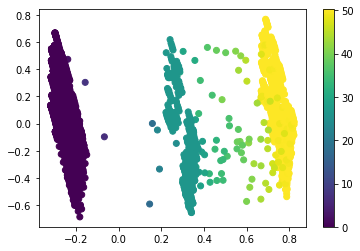

In [18]:
plt.scatter(new_df["pca 1"], new_df["pca 2"], alpha=1, c=new_df["blower_hz"], cmap="viridis")
plt.colorbar()

Por lo tanto, los modelos de clustering a probar:

* K-Means.
* DBSCAN.
* Hierarchical clustering.

### 5.1 K-means

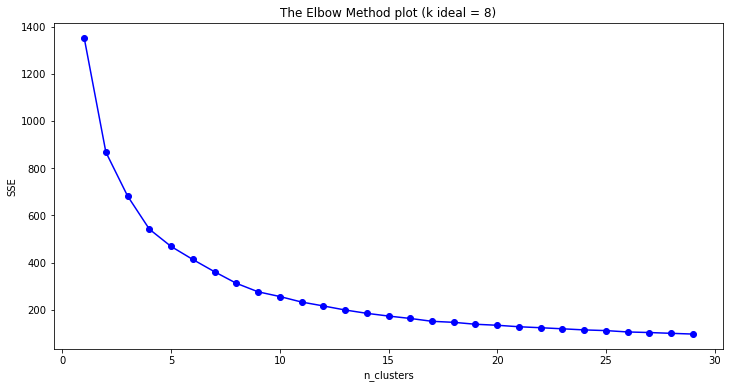

In [19]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

new_df_kmeans = new_df.copy()
scaled_columns = [col+"_scaled" for col in ['do_level', 'h2o_level', 'cycle_id', 'blower_hz']]

def Elbow_Method(data, n_clusters, columns, **kwargs):
    sse = []
    data = data.filter(columns)
    for k in n_clusters:
        kmeans_model = KMeans(n_clusters=k, random_state=42)
        kmeans_model.fit(data)
        sse.append(kmeans_model.inertia_)

    kl = KneeLocator(
        n_clusters, sse, curve="convex", direction="decreasing"
    )
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(n_clusters, sse, 'bo-')
    ax.set_xlabel('n_clusters')
    ax.set_ylabel('SSE')
    ax.set_title('The Elbow Method plot (k ideal = '+str(kl.elbow)+')')
    return

Elbow_Method(new_df_kmeans, n_clusters=range(1,30), columns=scaled_columns)

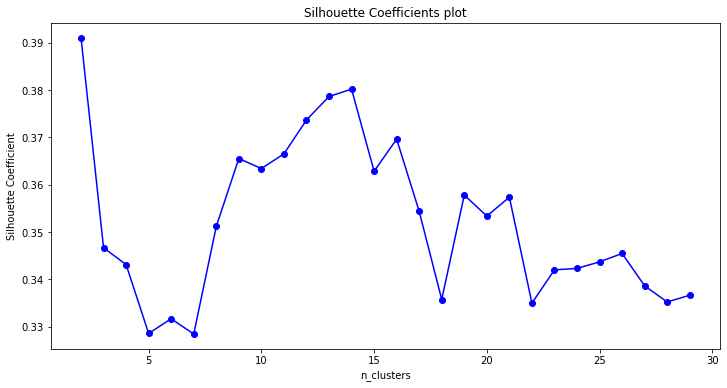

In [20]:
def Silhouette_Coefficient_kmeans(data, n_clusters, columns, **kwargs):
    # n_clusters >= 2
    silhouette_coefficients = []
    data = data.filter(columns)
    
    for k in n_clusters:
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(data)
        score = silhouette_score(data, model.labels_, random_state=42)
        silhouette_coefficients.append(score)
    
#     plt.style.use("fivethirtyeight")

    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(n_clusters, silhouette_coefficients, 'bo-')
    ax.set_xlabel('n_clusters')
    ax.set_ylabel("Silhouette Coefficient")
    ax.set_title('Silhouette Coefficients plot')
    return

Silhouette_Coefficient_kmeans(new_df_kmeans, n_clusters=range(2,30), columns=scaled_columns)

De acuerdo a ambos metodos usados, el primer metodo entrega un número de cluster igual a 7, mientras que el segundo metodo presenta un valor máximo para un número de clusters igual a 2. Por lo tanto, se grafican ambas.

do_level  h2o_level  blower_hz  cycle_id  do_level_scaled  \
0  1.693960   4.931112        0.0         0         0.295746   
1  1.401860   4.930655        0.0         0         0.244601   
2  1.134430   4.929771        0.0         0         0.197775   
3  0.929321   4.930228        0.0         0         0.161861   
4  0.882311   4.928187        0.0         0         0.153630   

   h2o_level_scaled  blower_hz_scaled  cycle_id_scaled     pca 1     pca 2  \
0          0.679715               0.0              0.0 -0.286776 -0.117809   
1          0.679410               0.0              0.0 -0.288848 -0.106826   
2          0.678822               0.0              0.0 -0.290702 -0.097021   
3          0.679126               0.0              0.0 -0.292227 -0.088888   
4          0.677767               0.0              0.0 -0.292383 -0.088184   

   kmeans_label1  kmeans_label2  
0              0              1  
1              0              1  
2              0              1  
3              0              1  
4              0              1

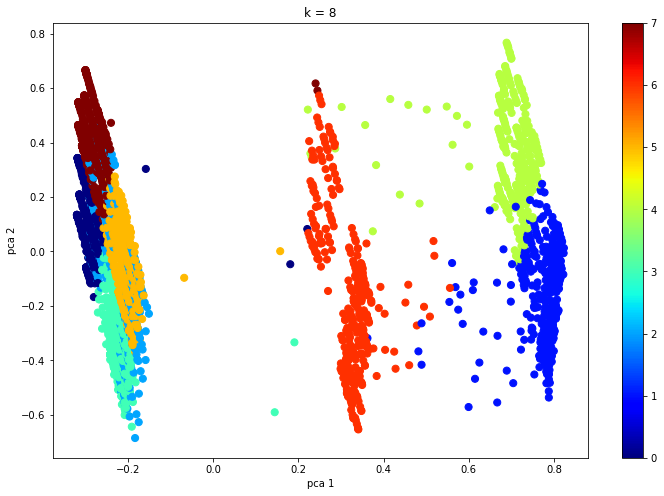

In [21]:
kmeans_model1 = KMeans(n_clusters = 8, random_state=42)
kmeans_model1.fit(new_df_kmeans.filter(scaled_columns))
new_df_kmeans["kmeans_label1"] = kmeans_model1.labels_

kmeans_model2 = KMeans(n_clusters = 2, random_state=42)
kmeans_model2.fit(new_df_kmeans.filter(scaled_columns))
new_df_kmeans["kmeans_label2"] = kmeans_model2.labels_

display(new_df_kmeans.head())

fig, ax = plt.subplots(figsize = (12, 8))
scatter = ax.scatter(new_df_kmeans["pca 1"], new_df_kmeans["pca 2"], c = new_df_kmeans["kmeans_label1"], alpha=1, s=50, cmap="jet")
ax.set_xlabel("pca 1")
ax.set_ylabel("pca 2")
ax.set_title("k = 8")
plt.colorbar(scatter)

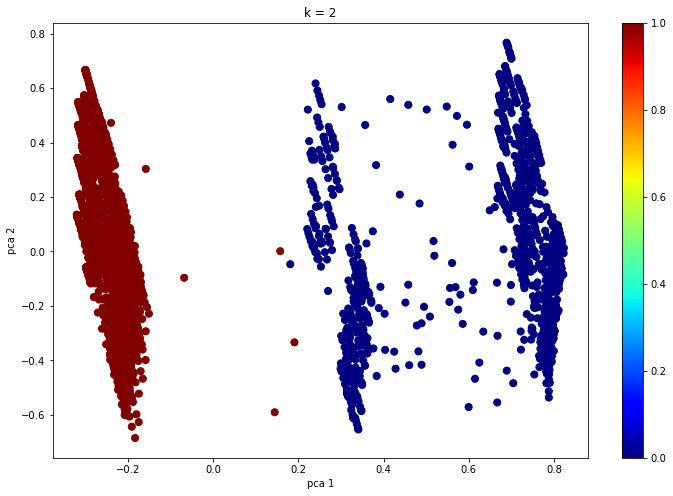

In [22]:
fig, ax = plt.subplots(figsize = (12, 8))
scatter = ax.scatter(new_df_kmeans["pca 1"], new_df_kmeans["pca 2"], c = new_df_kmeans["kmeans_label2"], alpha=1, s=50, cmap="jet")
ax.set_xlabel("pca 1")
ax.set_ylabel("pca 2")
ax.set_title("k = 2")
plt.colorbar(scatter)

In [23]:
print(new_df_kmeans["kmeans_label1"].unique())
print(new_df_kmeans["kmeans_label2"].unique())

[0 3 1 6 2 4 5 7]
[1 0]


### 5.2 DBSCAN

In [24]:
from sklearn.cluster import DBSCAN

new_df_dbscan = new_df.copy()
scaled_columns = [col+"_scaled" for col in ['do_level', 'h2o_level', 'cycle_id', 'blower_hz']]

def Silhouette_Coefficient_DBSCAN(data, columns, parameters, **kwargs):
    silhouette_coefficients = []
    data_filter = data.filter(columns)
    
    for eps in parameters["eps"]:
        for min_samples in parameters["min_samples"]:
            dbscan = DBSCAN(eps = eps, min_samples = min_samples)
            preds  = dbscan.fit_predict(data_filter)
            if np.unique(preds)[0] == -1:
                pass
            else:
                score  = silhouette_score(data_filter, preds)
                silhouette_coefficients.append([eps, min_samples, score])
    silhouette_coefficients = pd.DataFrame(silhouette_coefficients, columns = ["eps","min_samples","score"])
    return silhouette_coefficients.sort_values("score", ascending=False)

parameters = {
    "eps"         : np.arange(0.1, 0.5+0.05, 0.05),
    "min_samples" : np.arange(200, 250+5, 5)
}
results = Silhouette_Coefficient_DBSCAN(data=new_df_dbscan, columns=scaled_columns, parameters = parameters)
results.head(10)

Empty DataFrame
Columns: [eps, min_samples, score]
Index: []

### 5.3 Hierarchical clustering.

In [25]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

new_df_sch = new_df.copy()
scaled_columns = [col+"_scaled" for col in ['do_level', 'h2o_level', 'cycle_id', 'blower_hz']]

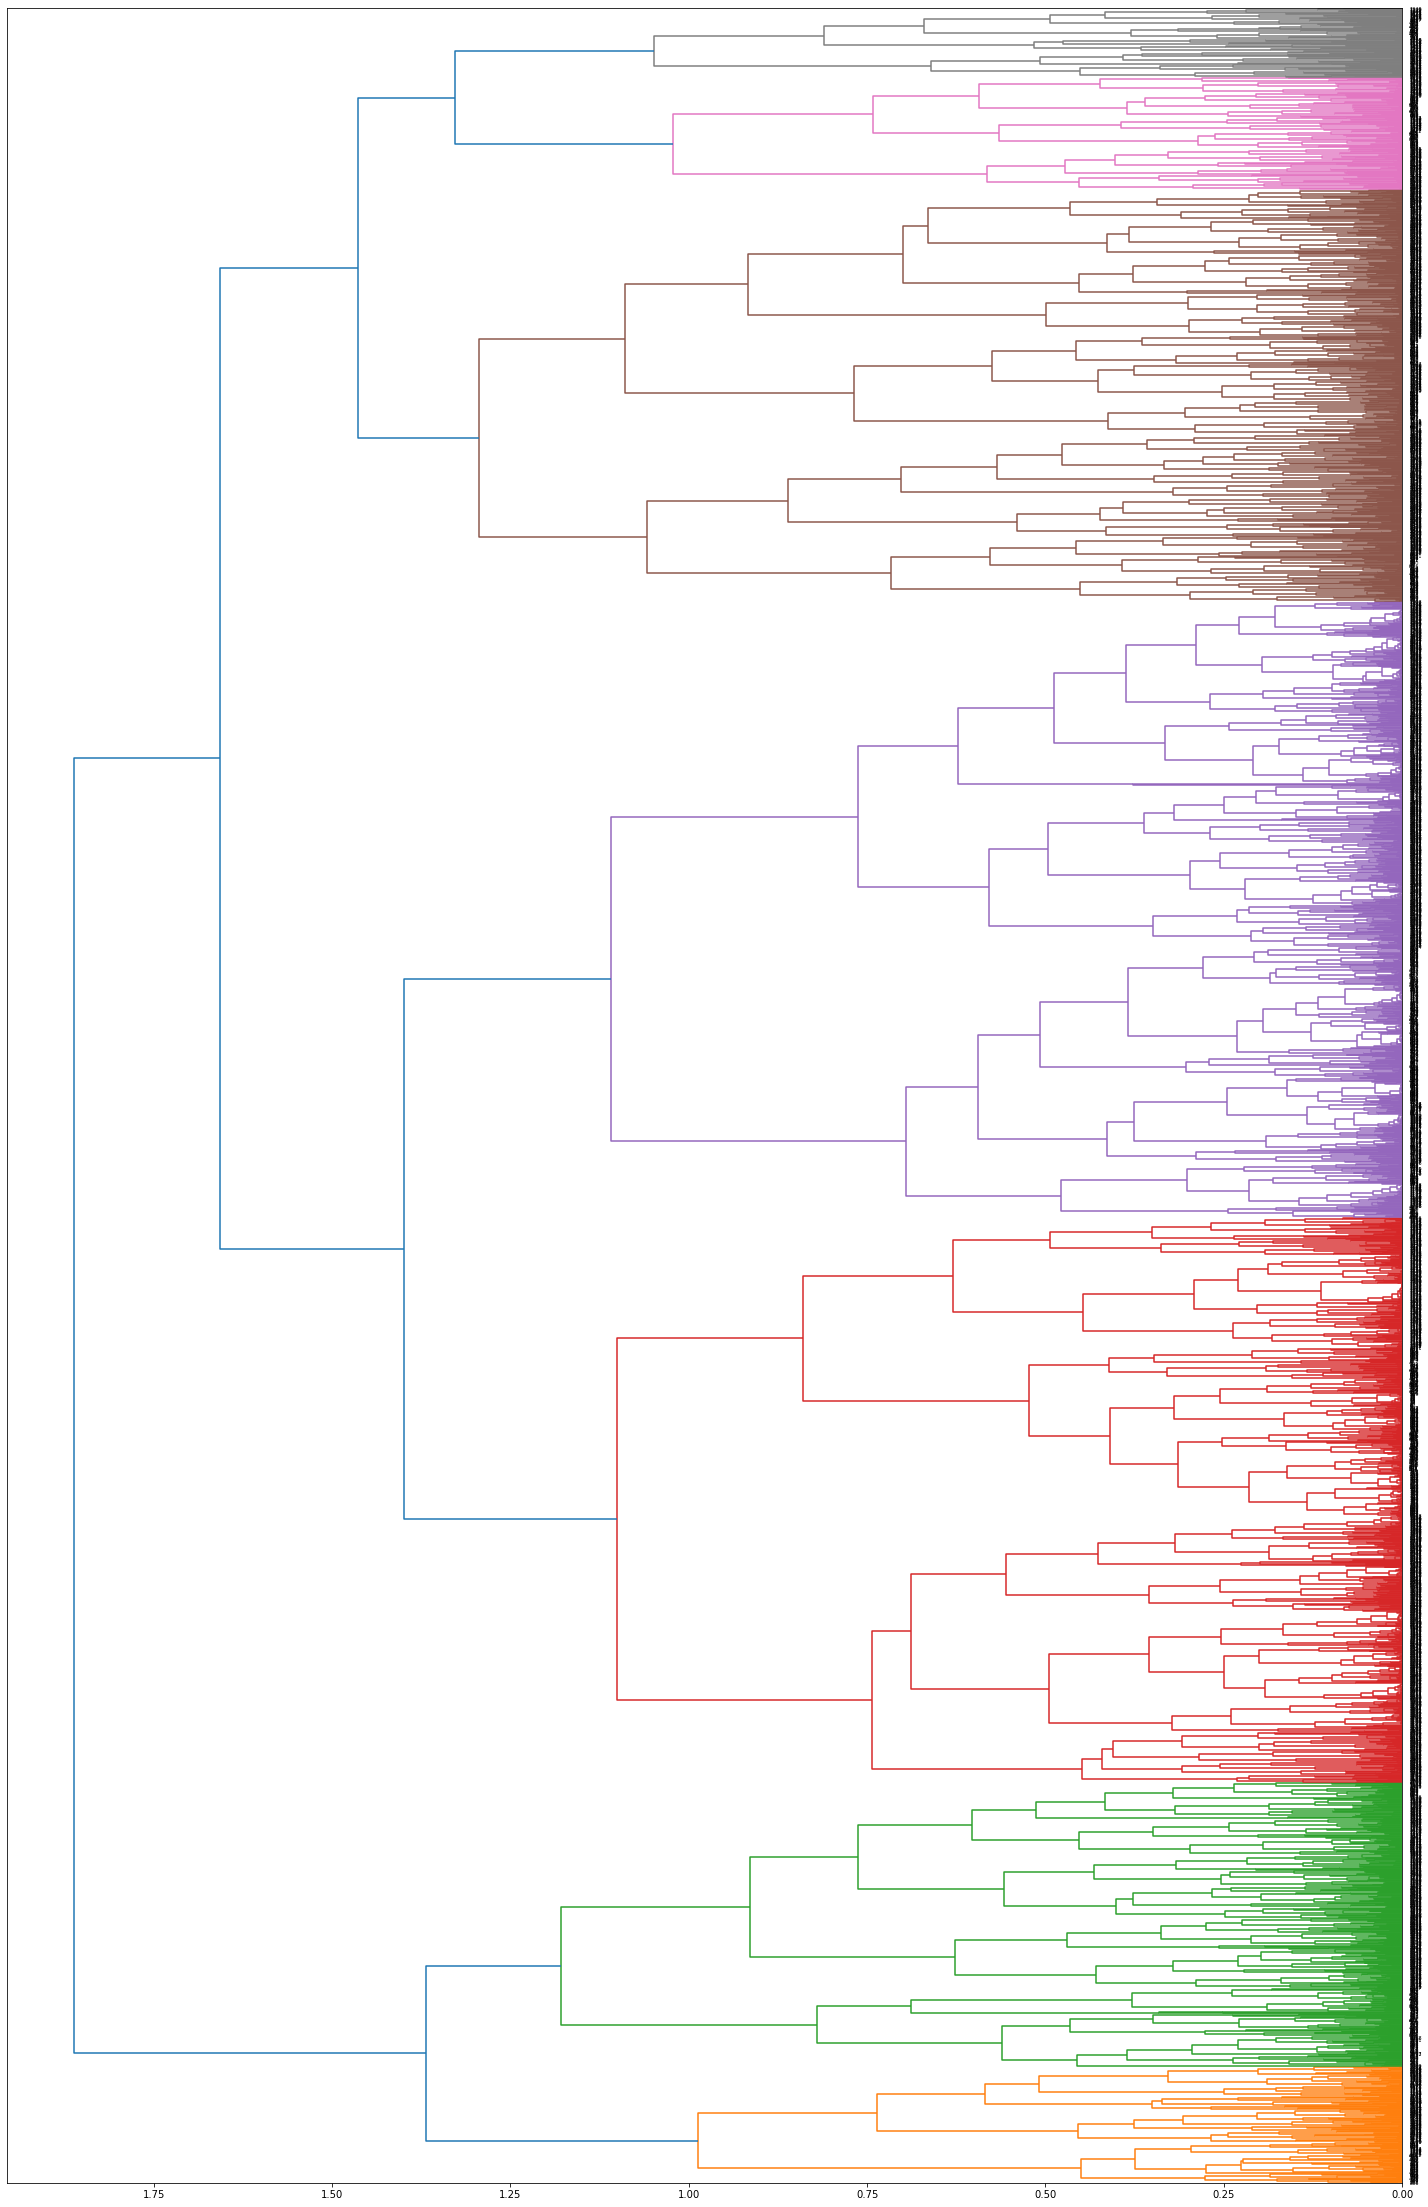

In [26]:
plt.figure(figsize=(25, 40))
# plt.plot([0,1],[0,1])
_ = dendrogram(linkage(new_df_sch[scaled_columns], method='complete'), orientation="left")

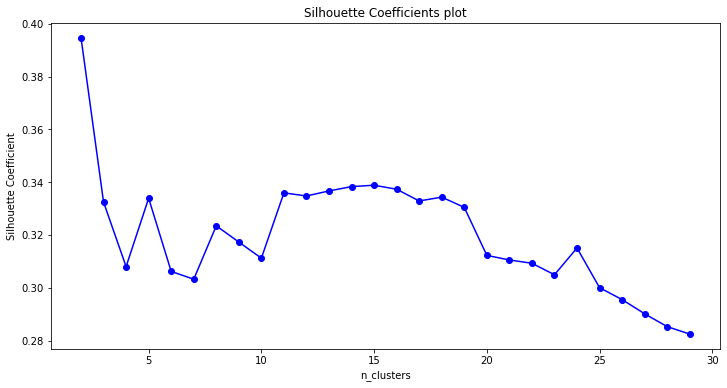

In [27]:
from sklearn.cluster import AgglomerativeClustering

def Silhouette_Coefficient_sch(data, n_clusters, columns, **kwargs):
    # n_clusters >= 2
    silhouette_coefficients = []
    data = data.filter(columns)
    
    for k in n_clusters:
        sch_model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='complete')
        sch_model.fit(data)
        score = silhouette_score(data, sch_model.labels_, random_state=42)
        silhouette_coefficients.append(score)
    
#     plt.style.use("fivethirtyeight")

    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(n_clusters, silhouette_coefficients, 'bo-')
    ax.set_xlabel('n_clusters')
    ax.set_ylabel("Silhouette Coefficient")
    ax.set_title('Silhouette Coefficients plot')
    return

Silhouette_Coefficient_sch(new_df_sch, n_clusters=range(2,30), columns=scaled_columns)

do_level  h2o_level  blower_hz  cycle_id  do_level_scaled  \
0  1.693960   4.931112        0.0         0         0.295746   
1  1.401860   4.930655        0.0         0         0.244601   
2  1.134430   4.929771        0.0         0         0.197775   
3  0.929321   4.930228        0.0         0         0.161861   
4  0.882311   4.928187        0.0         0         0.153630   

   h2o_level_scaled  blower_hz_scaled  cycle_id_scaled     pca 1     pca 2  \
0          0.679715               0.0              0.0 -0.286776 -0.117809   
1          0.679410               0.0              0.0 -0.288848 -0.106826   
2          0.678822               0.0              0.0 -0.290702 -0.097021   
3          0.679126               0.0              0.0 -0.292227 -0.088888   
4          0.677767               0.0              0.0 -0.292383 -0.088184   

   sch_label  
0          0  
1          0  
2          0  
3          0  
4          0

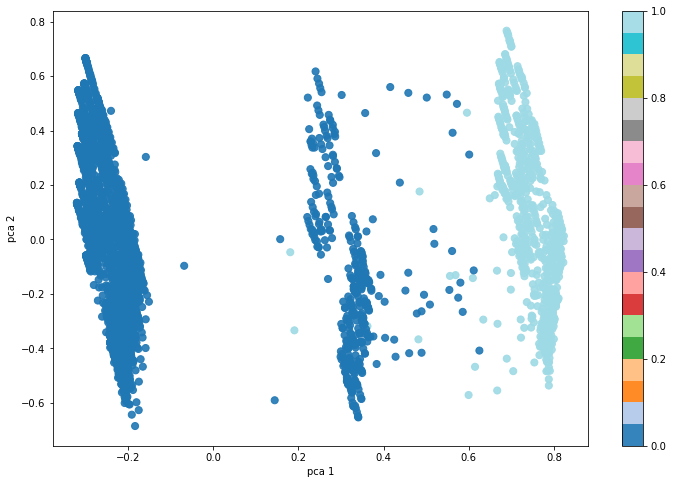

In [28]:
sch_model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
sch_model.fit(new_df_sch.filter(scaled_columns))

new_df_sch["sch_label"] = sch_model.labels_
display(new_df_sch.head())

fig, ax = plt.subplots(figsize = (12, 8))
scatter = ax.scatter(new_df_sch["pca 1"], new_df_sch["pca 2"], c = new_df_sch["sch_label"], alpha=0.9, s=50, cmap='tab20')
ax.set_xlabel("pca 1")
ax.set_ylabel("pca 2")
plt.colorbar(scatter)

In [29]:
new_df_sch["sch_label"].unique()

array([0, 1], dtype=int64)

### 5.4 Comparación modelos.

In [30]:
score_1 = silhouette_score(new_df_kmeans.filter(scaled_columns), kmeans_model1.labels_, random_state=42)
score_2 = silhouette_score(new_df_kmeans.filter(scaled_columns), kmeans_model2.labels_, random_state=42)
score_3 = silhouette_score(new_df_sch.filter(scaled_columns), sch_model.labels_, random_state=42)
print(f"k-means, n_cluster = 8, score: {score_1:.5f}")
print(f"k-means, n_cluster = 2, score: {score_2:.5f}")
print(f"AgglomerativeClustering, n_cluster = 2, score: {score_3:.5f}")

k-means, n_cluster = 8, score: 0.35119
k-means, n_cluster = 2, score: 0.39110
AgglomerativeClustering, n_cluster = 2, score: 0.39484


1) El modelo DBSCAN no logra encontrar los parámetros optimos.
2) De acuerdo al coeficiente de silueta, un modelo del tipo "AgglomerativeClustering" con n_cluster = 2 representa los datos.
3) Se observa sesgo al considerar valores de blower_hz = 0 desde el resumen estadístico hasta cada uno de los modelos, por lo tanto se recomienda considerar valores superiores a 0.

### 5.5 Con blower_hz > 0

do_level  h2o_level  blower_hz  cycle_id  do_level_scaled  \
0  0.013041   3.920697  50.220001         1         0.001466   
1  1.127790   3.945590  50.209999         1         0.206818   
2  1.914550   3.959394  49.990002         1         0.351750   
3  2.290200   3.957566  40.279999         1         0.420949   
4  2.619390   3.955097  26.420000         1         0.481590   

   h2o_level_scaled  blower_hz_scaled  cycle_id_scaled     pca 1     pca 2  
0          0.004232          0.999585              0.0 -0.069821 -0.714001  
1          0.020854          0.999377              0.0  0.063134 -0.628697  
2          0.030070          0.994808              0.0  0.160552 -0.569043  
3          0.028850          0.793146              0.0  0.321577 -0.488537  
4          0.027201          0.505296              0.0  0.525368 -0.387184

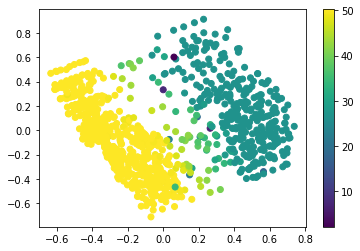

In [31]:
new_df_2 = PCA_values(df=df.query("blower_hz > 0"), columns=['do_level', 'h2o_level','blower_hz', 'cycle_id'], scaler=MinMaxScaler())
display(new_df_2.head())

plt.scatter(new_df_2["pca 1"], new_df_2["pca 2"], alpha=1, c=new_df_2["blower_hz"], cmap="viridis")
plt.colorbar()

#### 5.51 K-Means

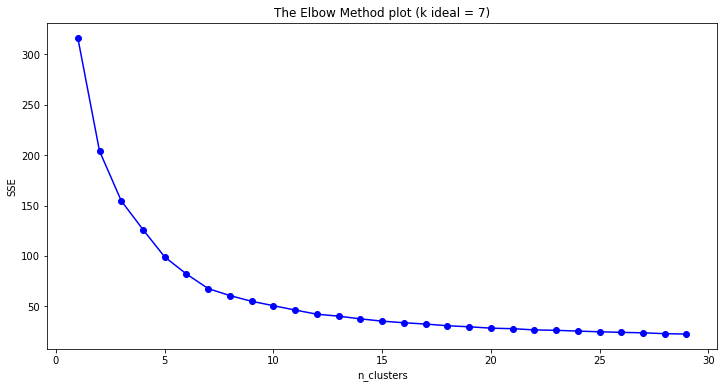

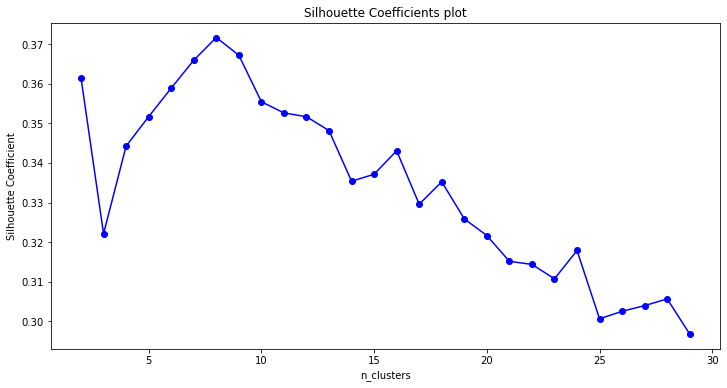

In [32]:
Elbow_Method(new_df_2, n_clusters=range(1,30), columns=scaled_columns)
Silhouette_Coefficient_kmeans(new_df_2, n_clusters=range(2,30), columns=scaled_columns)

In [33]:
kmeans_model3 = KMeans(n_clusters = 7, random_state=42)
kmeans_model3.fit(new_df_2.filter(scaled_columns))
new_df_2["kmeans_label3"] = kmeans_model3.labels_

kmeans_model4 = KMeans(n_clusters = 8, random_state=42)
kmeans_model4.fit(new_df_2.filter(scaled_columns))
new_df_2["kmeans_label4"] = kmeans_model4.labels_

display(new_df_2.head())

do_level  h2o_level  blower_hz  cycle_id  do_level_scaled  \
0  0.013041   3.920697  50.220001         1         0.001466   
1  1.127790   3.945590  50.209999         1         0.206818   
2  1.914550   3.959394  49.990002         1         0.351750   
3  2.290200   3.957566  40.279999         1         0.420949   
4  2.619390   3.955097  26.420000         1         0.481590   

   h2o_level_scaled  blower_hz_scaled  cycle_id_scaled     pca 1     pca 2  \
0          0.004232          0.999585              0.0 -0.069821 -0.714001   
1          0.020854          0.999377              0.0  0.063134 -0.628697   
2          0.030070          0.994808              0.0  0.160552 -0.569043   
3          0.028850          0.793146              0.0  0.321577 -0.488537   
4          0.027201          0.505296              0.0  0.525368 -0.387184   

   kmeans_label3  kmeans_label4  
0              6              1  
1              6              1  
2              6              1  
3              6              1  
4              3              3

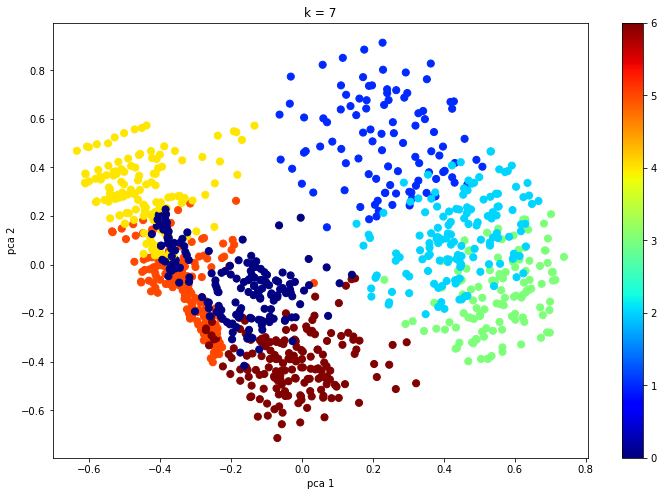

In [34]:
fig, ax = plt.subplots(figsize = (12, 8))
scatter = ax.scatter(new_df_2["pca 1"], new_df_2["pca 2"], c = new_df_2["kmeans_label3"], alpha=1, s=50, cmap="jet")
ax.set_xlabel("pca 1")
ax.set_ylabel("pca 2")
ax.set_title("k = 7")
plt.colorbar(scatter)

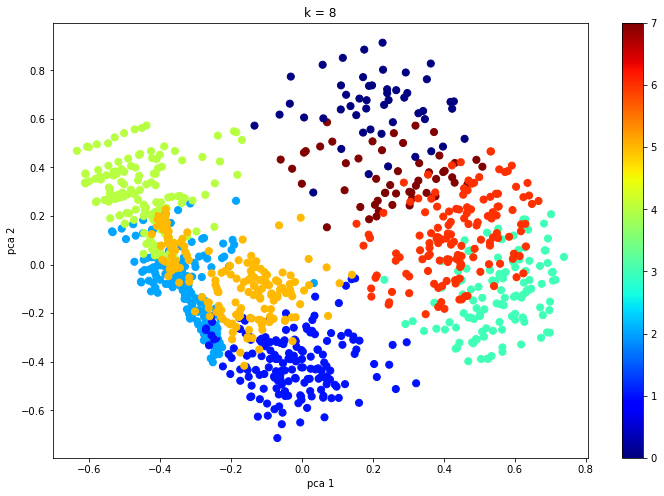

In [35]:
fig, ax = plt.subplots(figsize = (12, 8))
scatter = ax.scatter(new_df_2["pca 1"], new_df_2["pca 2"], c = new_df_2["kmeans_label4"], alpha=1, s=50, cmap="jet")
ax.set_xlabel("pca 1")
ax.set_ylabel("pca 2")
ax.set_title("k = 8")
plt.colorbar(scatter)

#### 5.52 DBSCAN

In [36]:
def Silhouette_Coefficient_DBSCAN(data, columns, parameters, **kwargs):
    silhouette_coefficients = []
    data_filter = data.filter(columns)
    
    for eps in parameters["eps"]:
        for min_samples in parameters["min_samples"]:
            dbscan = DBSCAN(eps = eps, min_samples = min_samples)
            preds  = dbscan.fit_predict(data_filter)
            if np.unique(preds)[0] == -1:
                pass
            else:
                score  = silhouette_score(data_filter, preds)
                silhouette_coefficients.append([eps, min_samples, score])
    silhouette_coefficients = pd.DataFrame(silhouette_coefficients, columns = ["eps","min_samples","score"])
    return silhouette_coefficients.sort_values("score", ascending=False)

parameters = {
    "eps"         : np.arange(0.1, .5+0.1, 0.1),
    "min_samples" : np.arange(5, 200+5, 5)
}
results = Silhouette_Coefficient_DBSCAN(data=new_df_2, columns=scaled_columns, parameters = parameters)
results.head(10)

Empty DataFrame
Columns: [eps, min_samples, score]
Index: []

#### 5.5.3 Hierarchical clustering.

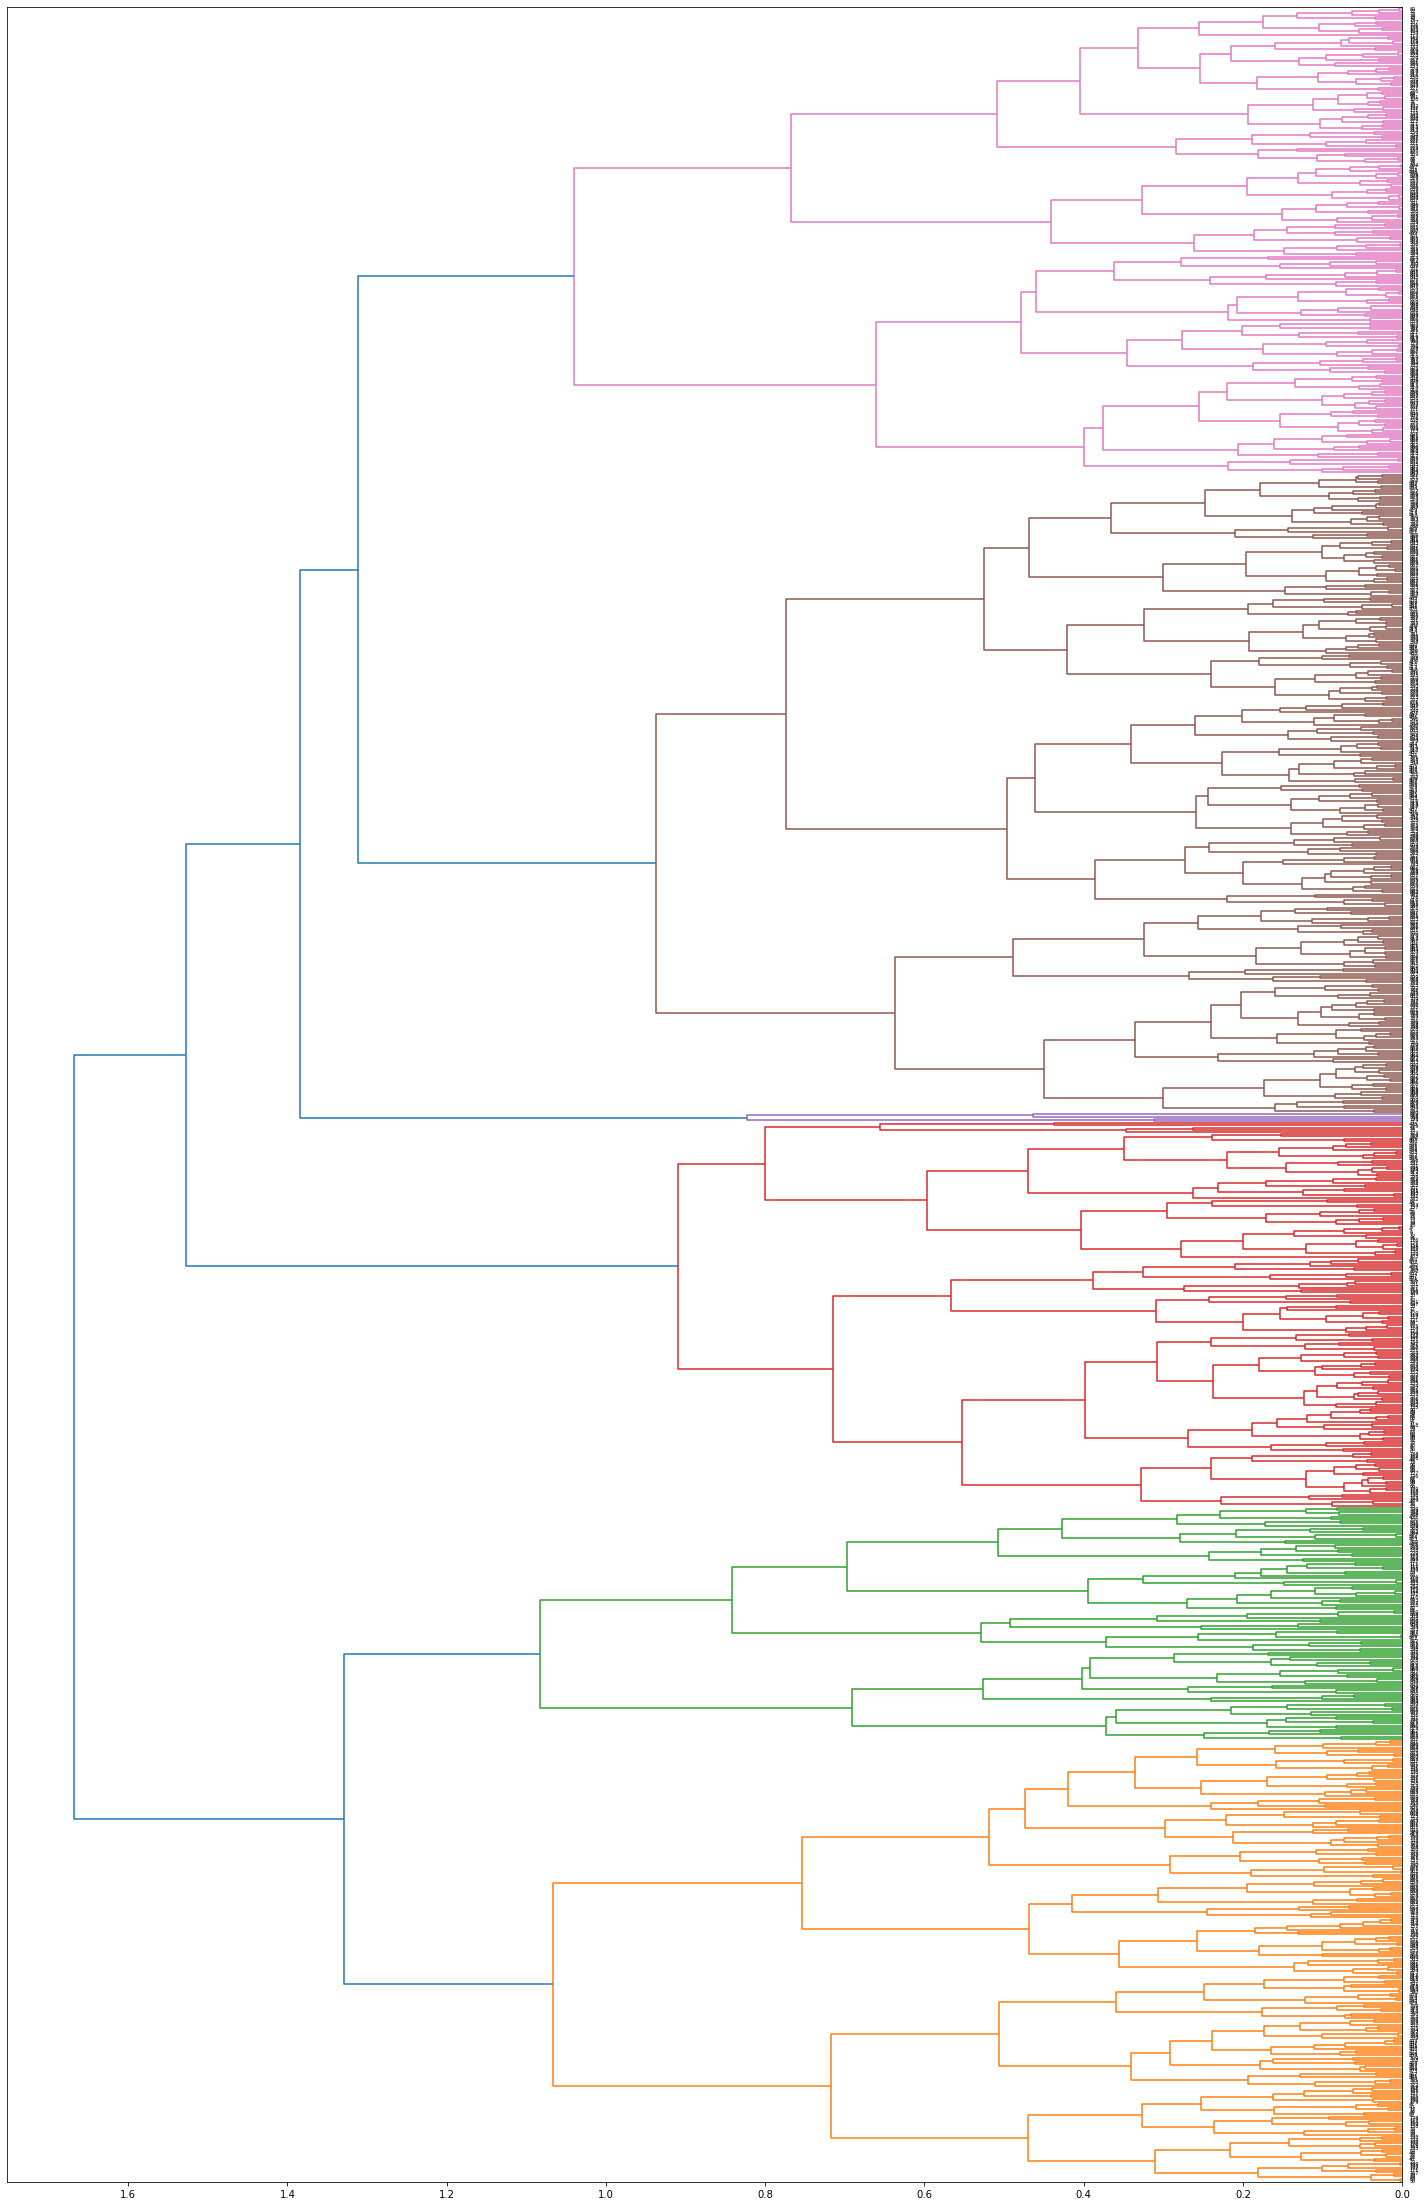

In [37]:
plt.figure(figsize=(25, 40))
# plt.plot([0,1],[0,1])
_ = dendrogram(linkage(new_df_2[scaled_columns], method='complete'), orientation="left")

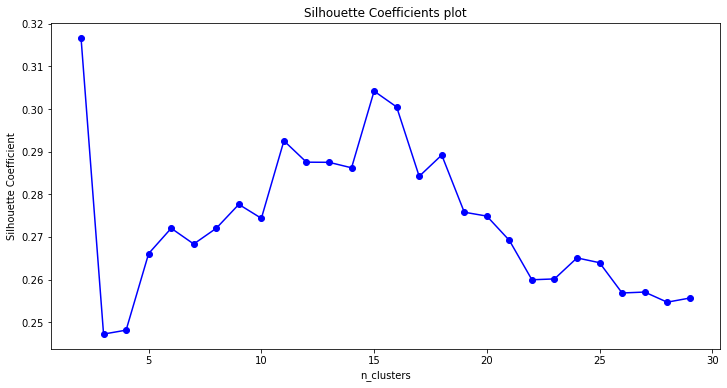

In [38]:
Silhouette_Coefficient_sch(new_df_2, n_clusters=range(2,30), columns=scaled_columns)

In [39]:
sch_model2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
sch_model2.fit(new_df_2.filter(scaled_columns))

new_df_2["sch_label"] = sch_model2.labels_
display(new_df_2.head())

do_level  h2o_level  blower_hz  cycle_id  do_level_scaled  \
0  0.013041   3.920697  50.220001         1         0.001466   
1  1.127790   3.945590  50.209999         1         0.206818   
2  1.914550   3.959394  49.990002         1         0.351750   
3  2.290200   3.957566  40.279999         1         0.420949   
4  2.619390   3.955097  26.420000         1         0.481590   

   h2o_level_scaled  blower_hz_scaled  cycle_id_scaled     pca 1     pca 2  \
0          0.004232          0.999585              0.0 -0.069821 -0.714001   
1          0.020854          0.999377              0.0  0.063134 -0.628697   
2          0.030070          0.994808              0.0  0.160552 -0.569043   
3          0.028850          0.793146              0.0  0.321577 -0.488537   
4          0.027201          0.505296              0.0  0.525368 -0.387184   

   kmeans_label3  kmeans_label4  sch_label  
0              6              1          0  
1              6              1          0  
2              6              1          0  
3              6              1          0  
4              3              3          0

### 5.6 Conclusiones Finales

In [49]:
from sklearn import metrics
score_1 = silhouette_score(new_df_kmeans.filter(scaled_columns), kmeans_model1.labels_, random_state=42)
score_2 = silhouette_score(new_df_kmeans.filter(scaled_columns), kmeans_model2.labels_, random_state=42)
score_3 = silhouette_score(new_df_sch.filter(scaled_columns), sch_model.labels_, random_state=42)
print(f"k-means, n_cluster = 8, silhouette_score: {score_1:.5f}")
print(f"k-means, n_cluster = 2,  silhouette_score: {score_2:.5f}")
print(f"AgglomerativeClustering, n_cluster = 2,  silhouette_score: {score_3:.5f}")
print("#######################################################")
score_1 = metrics.calinski_harabasz_score(new_df_kmeans.filter(scaled_columns), kmeans_model1.labels_)
score_2 = metrics.calinski_harabasz_score(new_df_kmeans.filter(scaled_columns), kmeans_model2.labels_)
score_3 = metrics.calinski_harabasz_score(new_df_sch.filter(scaled_columns), sch_model.labels_)
print(f"k-means, n_cluster = 8, calinski_harabasz_score: {score_1:.5f}")
print(f"k-means, n_cluster = 2, calinski_harabasz_score: {score_2:.5f}")
print(f"AgglomerativeClustering, n_cluster = 2, calinski_harabasz_score: {score_3:.5f}")
print("#######################################################")
score_1 = metrics.davies_bouldin_score(new_df_kmeans.filter(scaled_columns), kmeans_model1.labels_)
score_2 = metrics.davies_bouldin_score(new_df_kmeans.filter(scaled_columns), kmeans_model2.labels_)
score_3 = metrics.davies_bouldin_score(new_df_sch.filter(scaled_columns), sch_model.labels_)
print(f"k-means, n_cluster = 8, davies_bouldin_score: {score_1:.5f}")
print(f"k-means, n_cluster = 2, davies_bouldin_score: {score_2:.5f}")
print(f"AgglomerativeClustering, n_cluster = 2, davies_bouldin_score: {score_3:.5f}")

k-means, n_cluster = 8, silhouette_score: 0.35119
k-means, n_cluster = 2,  silhouette_score: 0.39110
AgglomerativeClustering, n_cluster = 2,  silhouette_score: 0.39484
#######################################################
k-means, n_cluster = 8, calinski_harabasz_score: 1596.71655
k-means, n_cluster = 2, calinski_harabasz_score: 1881.78647
AgglomerativeClustering, n_cluster = 2, calinski_harabasz_score: 1594.52080
#######################################################
k-means, n_cluster = 8, davies_bouldin_score: 1.07915
k-means, n_cluster = 2, davies_bouldin_score: 1.19922
AgglomerativeClustering, n_cluster = 2, davies_bouldin_score: 1.00619


In [51]:
score_1 = silhouette_score(new_df_2.filter(scaled_columns), new_df_2["kmeans_label3"], random_state=42)
score_2 = silhouette_score(new_df_2.filter(scaled_columns), new_df_2["kmeans_label4"], random_state=42)
score_3 = silhouette_score(new_df_2.filter(scaled_columns), new_df_2["sch_label"], random_state=42)
print(f"k-means, n_cluster = 7, silhouette_score: {score_1:.5f}")
print(f"k-means, n_cluster = 8, silhouette_score: {score_2:.5f}")
print(f"AgglomerativeClustering, n_cluster = 2, silhouette_score: {score_3:.5f}")
print("#######################################################")
score_1 = metrics.calinski_harabasz_score(new_df_2.filter(scaled_columns), new_df_2["kmeans_label3"])
score_2 = metrics.calinski_harabasz_score(new_df_2.filter(scaled_columns), new_df_2["kmeans_label4"])
score_3 = metrics.calinski_harabasz_score(new_df_2.filter(scaled_columns), new_df_2["sch_label"])
print(f"k-means, n_cluster = 7, calinski_harabasz_score: {score_1:.5f}")
print(f"k-means, n_cluster = 8, calinski_harabasz_score: {score_2:.5f}")
print(f"AgglomerativeClustering, n_cluster = 2, calinski_harabasz_score: {score_3:.5f}")
print("#######################################################")
score_1 = metrics.davies_bouldin_score(new_df_2.filter(scaled_columns), new_df_2["kmeans_label3"])
score_2 = metrics.davies_bouldin_score(new_df_2.filter(scaled_columns), new_df_2["kmeans_label4"])
score_3 = metrics.davies_bouldin_score(new_df_2.filter(scaled_columns), new_df_2["sch_label"])
print(f"k-means, n_cluster = 7, davies_bouldin_score: {score_1:.5f}")
print(f"k-means, n_cluster = 8, davies_bouldin_score: {score_2:.5f}")
print(f"AgglomerativeClustering, n_cluster = 2, davies_bouldin_score: {score_3:.5f}")

k-means, n_cluster = 7, silhouette_score: 0.36592
k-means, n_cluster = 8, silhouette_score: 0.37165
AgglomerativeClustering, n_cluster = 2, silhouette_score: 0.31676
#######################################################
k-means, n_cluster = 7, calinski_harabasz_score: 601.73452
k-means, n_cluster = 8, calinski_harabasz_score: 590.21804
AgglomerativeClustering, n_cluster = 2, calinski_harabasz_score: 415.40122
#######################################################
k-means, n_cluster = 7, davies_bouldin_score: 0.89383
k-means, n_cluster = 8, davies_bouldin_score: 0.89632
AgglomerativeClustering, n_cluster = 2, davies_bouldin_score: 1.34577


**Comentarios:**
1) El modelo DBSCAN otra vez no logra encontrar los parámetros optimos.
2) De acuerdo al coeficiente de silueta, el mejor modelo es del tipo "AgglomerativeClustering" con n_cluster = 2, considerando todos los datos, por otra parte un modelo k-means con n_cluster = 8 presenta mejor los datos cuendo se consideran Hz superiores a 0.
3) De acuerdo con la escala de Calinski y Harabasz, la variabilidad con todos los datos es superior a la variabilidad con los datos filtrados.
4) De acuerdo a la escala de Davies-Bouldin, los valores con el modelo k-means son menores cuando se filtran Hz superiores a 0, mientras en el caso del modelo "AgglomerativeClustering", este valor es superior, lo que indica una peor agrupación de los datos.
5) Finalmente, considerando todos los datos el mejor modelo es del tipo "AgglomerativeClustering" con n_cluster = 2, mientras que filtrando los momentos en que el motor del soplador se encuentra inactivo un modelo k-means con n_cluster = 8 es la mejor representación de los ciclos de esta semana.